# Claims Risk Modelling

<small>This notebook explores risk modelling for pet insurance claims.
The goal is to identify patterns in claim frequency and severity, quantify risk drivers, and build models that support pricing, underwriting, and portfolio management decisions.

The dataset includes:
- **Pets** (breed, age, species, household)
- **Products** (cover type, premium, limits)
- **Policies** (policy–pet relationships)
- **Claims** (dates, types, costs, outcomes)
- **Vet Visits** (location, cost patterns)

This notebook forms part of a wider analytics portfolio demonstrating data engineering, modelling, and business interpretation skills.

In [149]:
import pandas as pd
import numpy as np
import os
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

plt.style.use("seaborn-v0_8")
sns.color_palette('crest', as_cmap=True)
pd.set_option("display.max_columns", None)

# Load data
data_path = r"C:\Users\leebe\Documents\VScode\portfolio project\Pet Insurance Analytics Project\data\processed"

claims = pd.read_csv(os.path.join(data_path, 'fact_claims_summary.csv'))
customers = pd.read_csv(os.path.join(data_path, 'dim_customers.csv'))
products = pd.read_csv(os.path.join(data_path, 'dim_products.csv'))
vet_costs = pd.read_csv(os.path.join(data_path, 'fact_vet_costs.csv'))

In [150]:
#Create function to save figures with timestamped filenames
def save_fig(name):
    filename = f"{name}_{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    plt.savefig(
        fr"C:\Users\leebe\Documents\GitHub\Professional-Portfolio\Pet Insurance Analytics Project\images\{filename}",
        dpi=300,
        bbox_inches='tight'
    )

# Data Checks

In [151]:
# Check for duplicates
num_duplicates = claims.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    print("\nDuplicate rows:")
    print(claims[claims.duplicated(keep=False)])


Number of duplicate rows: 0


In [152]:
# Check for duplicates
num_duplicates = customers.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    print("\nDuplicate rows:")
    print(customers[customers.duplicated(keep=False)])


Number of duplicate rows: 0


In [153]:
# Check for duplicates
num_duplicates = vet_costs.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    print("\nDuplicate rows:")
    print(vet_costs[vet_costs.duplicated(keep=False)])


Number of duplicate rows: 5

Duplicate rows:
        visit_id  visit_date                  vet_clinic    visit_type  \
91088      37802  2025-06-18  Parkside Veterinary Centre     Emergency   
91089      37802  2025-06-18  Parkside Veterinary Centre     Emergency   
207537     86408  2025-09-18           Happy Paws Clinic  Consultation   
207538     86408  2025-09-18           Happy Paws Clinic  Consultation   
215919     89915  2026-01-18            PetCare Hospital     Follow-up   
215920     89915  2026-01-18            PetCare Hospital     Follow-up   
407838    169902  2025-11-14     Northside Animal Clinic   Diagnostics   
407839    169902  2025-11-14     Northside Animal Clinic   Diagnostics   
452108    188322  2025-11-09              Riverbank Vets     Emergency   
452110    188322  2025-11-09              Riverbank Vets     Emergency   

       treatment_code       description    cost  claim_id  policy_id  pet_id  \
91088             MED        Medication  138.43    168753  

In [154]:
# Drop duplicate rows from the dataframe
before = len(vet_costs)

vet_costs = vet_costs.drop_duplicates().reset_index(drop=True)

after = len(vet_costs)
removed = before - after

print(f"Duplicates removed: {removed}")
print(f"New dataframe size: {after} rows")

Duplicates removed: 5
New dataframe size: 599995 rows


In [155]:
# Check for duplicates
num_duplicates = products.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    print("\nDuplicate rows:")
    print(products[products.duplicated(keep=False)])


Number of duplicate rows: 0


In [156]:
# Clean product names in both tables
claims["product_name_clean"] = claims["product_name"].str.strip().str.lower()
products["product_name_clean"] = products["product_name"].str.strip().str.lower()

In [157]:
datasets = {
    "claims": claims,
    "customers": customers,
    "products": products,
    "vet_costs": vet_costs
}

for name, df in datasets.items():
    print(f"\n--- {name.upper()} ---")
    print("Rows:", len(df))
    print("Columns:", len(df.columns))
    display(df.head(3))


--- CLAIMS ---
Rows: 200000
Columns: 18


,claim_id,claim_date,claim_amount,status,diagnosis,policy_id,product_name,coverage_type,monthly_premium,pet_id,species,breed,age_at_claim,customer_id,customer_name,customer_city,customer_country,product_name_clean
0,15463,2023-11-20,150.67,Open,Ear Infection,1,Lifetime Premier,Lifetime,57.44,30289,Dog,Boxer,2,24094,Gerald Cook,Richardside,Russian Federation,lifetime premier
1,82583,2022-12-10,96.08,Open,Ear Infection,1,Lifetime Premier,Lifetime,57.44,30289,Dog,Boxer,1,24094,Gerald Cook,Richardside,Russian Federation,lifetime premier
2,169782,2022-07-07,461.61,Rejected,Pancreatitis,1,Lifetime Premier,Lifetime,57.44,30289,Dog,Boxer,1,24094,Gerald Cook,Richardside,Russian Federation,lifetime premier



--- CUSTOMERS ---
Rows: 60000
Columns: 9


,customer_id,full_name,city,country,pets_owned,policies_owned,total_claims,total_claim_amount,total_premiums_paid
0,1,Johnny Gonzalez,West James,Greece,1,0,0,NaN,NaN
1,2,Daniel Adkins,North Kristen,Faroe Islands,1,1,0,NaN,1185.45
2,3,Meredith Gardner,South Tiffany,Saudi Arabia,1,0,0,NaN,NaN



--- PRODUCTS ---
Rows: 27
Columns: 12


,product_id,product_name,coverage_type,monthly_premium,annual_limit,deductible,total_policies,total_claims,total_claim_amount,total_premium_collected,loss_ratio,product_name_clean
0,1,Lifetime Essential,Lifetime,28.33,2000,100,4431,7321,4635098.41,4412567.48,1.05,lifetime essential
1,2,Lifetime Plus,Lifetime,87.99,4000,75,4446,7409,4721727.36,13852969.62,0.34,lifetime plus
2,3,Lifetime Premier,Lifetime,57.44,1000,75,4446,7400,4751997.10,8999526.88,0.53,lifetime premier



--- VET_COSTS ---
Rows: 599995
Columns: 11


,visit_id,visit_date,vet_clinic,visit_type,treatment_code,description,cost,claim_id,policy_id,pet_id,customer_id
0,1,2026-01-09,Beacon Hill Animal Hospital,Consultation,CYTO,Cytology,357.70,119086,32999,17053,13568
1,1,2026-01-09,Beacon Hill Animal Hospital,Consultation,XRAY,X-Ray Imaging,333.93,119086,32999,17053,13568
2,1,2026-01-09,Beacon Hill Animal Hospital,Consultation,SURG,Surgery (General),595.36,119086,32999,17053,13568


In [158]:
numeric_cols = ["claim_amount", "total_claim_amount", "cost", "monthly_premium"]

for col in numeric_cols:
    for name, df in {
        "claims": claims,
        "products": products,
        "vet_costs": vet_costs
    }.items():
        
        if col in df.columns:
            print(f"\n{name}.{col}:")
            print("Min:", df[col].min())
            print("Max:", df[col].max())
            print("Mean:", df[col].mean())


claims.claim_amount:
Min: 60.01
Max: 4999.31
Mean: 639.5445948

products.total_claim_amount:
Min: 4524296.95
Max: 4958365.6
Mean: 4737367.3688888885

vet_costs.cost:
Min: 20.0
Max: 2999.96
Mean: 267.289945316211

claims.monthly_premium:
Min: 13.19
Max: 89.68
Mean: 48.890583

products.monthly_premium:
Min: 13.19
Max: 89.68
Mean: 48.822592592592585


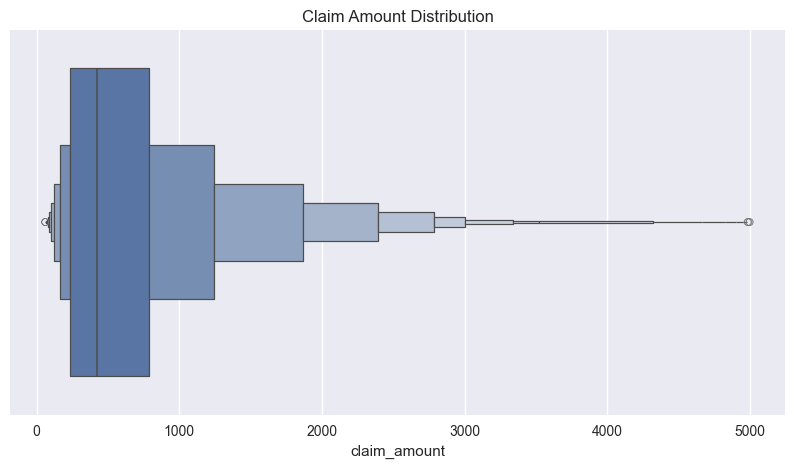

In [159]:
#Oulier check

plt.figure(figsize=(10,5))
sns.boxenplot(x=claims["claim_amount"])
plt.title("Claim Amount Distribution")
save_fig("claim_amount_outlier_check_boxplot")
plt.show()

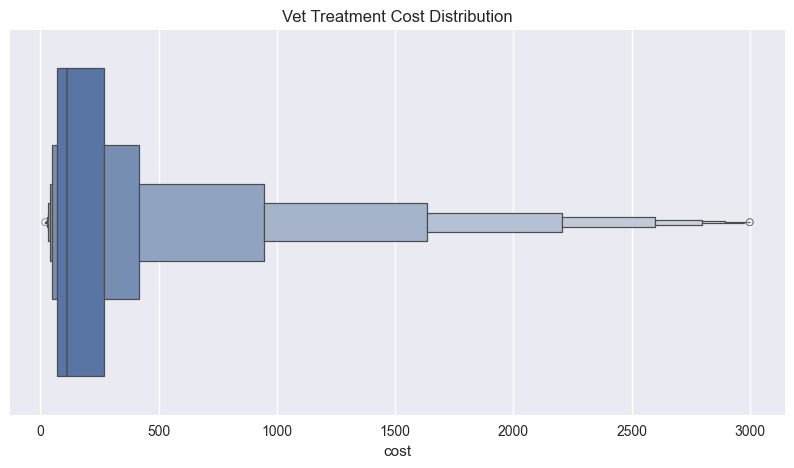

In [160]:
plt.figure(figsize=(10,5))
sns.boxenplot(x=vet_costs["cost"])
plt.title("Vet Treatment Cost Distribution")
save_fig("vet_cost__outlier_check_boxplot")
plt.show()

# Building dataset

### Aggregate Vet Costs to Claim Level
Each claim may have multiple visits and multiple treatments.
We need to roll these up to claim‑level severity.

In [161]:
# Aggregate vet costs to claim level
vet_agg = (
    vet_costs
    .groupby("claim_id")
    .agg(
        total_vet_cost=("cost", "sum"),
        num_treatments=("treatment_code", "count"),
        num_visits=("visit_id", "nunique"),
        most_common_clinic=("vet_clinic", lambda x: x.mode()[0] if not x.mode().empty else None)
    )
    .reset_index()
)

vet_agg.head()

,claim_id,total_vet_cost,num_treatments,num_visits,most_common_clinic
0,1,2709.87,4,2,Valley Veterinary Centre
1,2,80.13,1,1,PetCare Hospital
2,4,1505.66,8,3,Kingswood Pet Hospital
3,6,854.91,6,2,The Pet Wellness Centre
4,7,342.20,4,1,Millbrook Animal Health


### Merging claims to customers

In [162]:
claims_customers = claims.merge(customers, on="customer_id", how="left")


claims_customers.head()

,claim_id,claim_date,claim_amount,status,diagnosis,policy_id,product_name,coverage_type,monthly_premium,pet_id,species,breed,age_at_claim,customer_id,customer_name,customer_city,customer_country,product_name_clean,full_name,city,country,pets_owned,policies_owned,total_claims,total_claim_amount,total_premiums_paid
0,15463,2023-11-20,150.67,Open,Ear Infection,1,Lifetime Premier,Lifetime,57.44,30289,Dog,Boxer,2,24094,Gerald Cook,Richardside,Russian Federation,lifetime premier,Gerald Cook,Richardside,Russian Federation,1,2,6,2161.05,7309.74
1,82583,2022-12-10,96.08,Open,Ear Infection,1,Lifetime Premier,Lifetime,57.44,30289,Dog,Boxer,1,24094,Gerald Cook,Richardside,Russian Federation,lifetime premier,Gerald Cook,Richardside,Russian Federation,1,2,6,2161.05,7309.74
2,169782,2022-07-07,461.61,Rejected,Pancreatitis,1,Lifetime Premier,Lifetime,57.44,30289,Dog,Boxer,1,24094,Gerald Cook,Richardside,Russian Federation,lifetime premier,Gerald Cook,Richardside,Russian Federation,1,2,6,2161.05,7309.74
3,83918,2023-10-28,350.64,Open,Dental Issue,2,Lifetime Supreme,Lifetime,30.19,45173,Dog,Border Collie,15,35877,Jennifer Medina,East Sean,Mayotte,lifetime supreme,Jennifer Medina,East Sean,Mayotte,2,5,7,3183.57,7775.21
4,50069,2025-10-31,1474.60,Closed,Foreign Body Ingestion,3,Max Benefit 10k,Maximum Benefit,32.13,18891,Dog,Australian Shepherd,1,15056,Kyle Lewis,Roytown,Cayman Islands,max benefit 10k,Kyle Lewis,Roytown,Cayman Islands,1,1,1,1474.60,257.04


### Merging claims to products using product_name

In [163]:
claims_cust_prod = claims_customers.merge(
    products[["product_name_clean", "loss_ratio", "annual_limit", "deductible"]],
    on="product_name_clean",
    how="left"
)

# Drop duplicate columns
claims_cust_prod = claims_cust_prod.drop(
    columns=["coverage_type_prod", "monthly_premium_prod"],
    errors="ignore"
)

claims_cust_prod.head()

,claim_id,claim_date,claim_amount,status,diagnosis,policy_id,product_name,coverage_type,monthly_premium,pet_id,species,breed,age_at_claim,customer_id,customer_name,customer_city,customer_country,product_name_clean,full_name,city,country,pets_owned,policies_owned,total_claims,total_claim_amount,total_premiums_paid,loss_ratio,annual_limit,deductible
0,15463,2023-11-20,150.67,Open,Ear Infection,1,Lifetime Premier,Lifetime,57.44,30289,Dog,Boxer,2,24094,Gerald Cook,Richardside,Russian Federation,lifetime premier,Gerald Cook,Richardside,Russian Federation,1,2,6,2161.05,7309.74,0.53,1000,75
1,82583,2022-12-10,96.08,Open,Ear Infection,1,Lifetime Premier,Lifetime,57.44,30289,Dog,Boxer,1,24094,Gerald Cook,Richardside,Russian Federation,lifetime premier,Gerald Cook,Richardside,Russian Federation,1,2,6,2161.05,7309.74,0.53,1000,75
2,169782,2022-07-07,461.61,Rejected,Pancreatitis,1,Lifetime Premier,Lifetime,57.44,30289,Dog,Boxer,1,24094,Gerald Cook,Richardside,Russian Federation,lifetime premier,Gerald Cook,Richardside,Russian Federation,1,2,6,2161.05,7309.74,0.53,1000,75
3,83918,2023-10-28,350.64,Open,Dental Issue,2,Lifetime Supreme,Lifetime,30.19,45173,Dog,Border Collie,15,35877,Jennifer Medina,East Sean,Mayotte,lifetime supreme,Jennifer Medina,East Sean,Mayotte,2,5,7,3183.57,7775.21,1.01,8000,100
4,50069,2025-10-31,1474.60,Closed,Foreign Body Ingestion,3,Max Benefit 10k,Maximum Benefit,32.13,18891,Dog,Australian Shepherd,1,15056,Kyle Lewis,Roytown,Cayman Islands,max benefit 10k,Kyle Lewis,Roytown,Cayman Islands,1,1,1,1474.60,257.04,0.94,12000,50


### Merge Vet Cost Aggregates

In [164]:
model_df = claims_cust_prod.merge(
    vet_agg,
    on="claim_id",
    how="left"
)

model_df.head()

,claim_id,claim_date,claim_amount,status,diagnosis,policy_id,product_name,coverage_type,monthly_premium,pet_id,species,breed,age_at_claim,customer_id,customer_name,customer_city,customer_country,product_name_clean,full_name,city,country,pets_owned,policies_owned,total_claims,total_claim_amount,total_premiums_paid,loss_ratio,annual_limit,deductible,total_vet_cost,num_treatments,num_visits,most_common_clinic
0,15463,2023-11-20,150.67,Open,Ear Infection,1,Lifetime Premier,Lifetime,57.44,30289,Dog,Boxer,2,24094,Gerald Cook,Richardside,Russian Federation,lifetime premier,Gerald Cook,Richardside,Russian Federation,1,2,6,2161.05,7309.74,0.53,1000,75,96.77,2.0,1.0,Riverside Veterinary Group
1,82583,2022-12-10,96.08,Open,Ear Infection,1,Lifetime Premier,Lifetime,57.44,30289,Dog,Boxer,1,24094,Gerald Cook,Richardside,Russian Federation,lifetime premier,Gerald Cook,Richardside,Russian Federation,1,2,6,2161.05,7309.74,0.53,1000,75,NaN,NaN,NaN,NaN
2,169782,2022-07-07,461.61,Rejected,Pancreatitis,1,Lifetime Premier,Lifetime,57.44,30289,Dog,Boxer,1,24094,Gerald Cook,Richardside,Russian Federation,lifetime premier,Gerald Cook,Richardside,Russian Federation,1,2,6,2161.05,7309.74,0.53,1000,75,NaN,NaN,NaN,NaN
3,83918,2023-10-28,350.64,Open,Dental Issue,2,Lifetime Supreme,Lifetime,30.19,45173,Dog,Border Collie,15,35877,Jennifer Medina,East Sean,Mayotte,lifetime supreme,Jennifer Medina,East Sean,Mayotte,2,5,7,3183.57,7775.21,1.01,8000,100,3118.53,7.0,2.0,Forest Edge Vets
4,50069,2025-10-31,1474.60,Closed,Foreign Body Ingestion,3,Max Benefit 10k,Maximum Benefit,32.13,18891,Dog,Australian Shepherd,1,15056,Kyle Lewis,Roytown,Cayman Islands,max benefit 10k,Kyle Lewis,Roytown,Cayman Islands,1,1,1,1474.60,257.04,0.94,12000,50,2738.81,14.0,3.0,Riverside Veterinary Group


# Features

### Claim Severity

In [165]:
model_df["severity"] = model_df["claim_amount"]

### Age Buckets/Groups

In [166]:
model_df["age_at_claim"].describe()

count    200000.000000
mean          7.692610
std           5.297611
min          -3.000000
25%           3.000000
50%           8.000000
75%          12.000000
max          18.000000
Name: age_at_claim, dtype: float64

In [167]:
model_df = model_df[model_df["age_at_claim"] >= 0]

In [168]:
model_df["age_bucket"] = pd.cut(
    model_df["age_at_claim"],
    bins=[0, 1, 3, 7, 12, 30],
    labels=["0-1", "1-3", "3-7", "7-12", "12+"],
    include_lowest=True
)
model_df.head()

,claim_id,claim_date,claim_amount,status,diagnosis,policy_id,product_name,coverage_type,monthly_premium,pet_id,species,breed,age_at_claim,customer_id,customer_name,customer_city,customer_country,product_name_clean,full_name,city,country,pets_owned,policies_owned,total_claims,total_claim_amount,total_premiums_paid,loss_ratio,annual_limit,deductible,total_vet_cost,num_treatments,num_visits,most_common_clinic,severity,age_bucket
0,15463,2023-11-20,150.67,Open,Ear Infection,1,Lifetime Premier,Lifetime,57.44,30289,Dog,Boxer,2,24094,Gerald Cook,Richardside,Russian Federation,lifetime premier,Gerald Cook,Richardside,Russian Federation,1,2,6,2161.05,7309.74,0.53,1000,75,96.77,2.0,1.0,Riverside Veterinary Group,150.67,1-3
1,82583,2022-12-10,96.08,Open,Ear Infection,1,Lifetime Premier,Lifetime,57.44,30289,Dog,Boxer,1,24094,Gerald Cook,Richardside,Russian Federation,lifetime premier,Gerald Cook,Richardside,Russian Federation,1,2,6,2161.05,7309.74,0.53,1000,75,NaN,NaN,NaN,NaN,96.08,0-1
2,169782,2022-07-07,461.61,Rejected,Pancreatitis,1,Lifetime Premier,Lifetime,57.44,30289,Dog,Boxer,1,24094,Gerald Cook,Richardside,Russian Federation,lifetime premier,Gerald Cook,Richardside,Russian Federation,1,2,6,2161.05,7309.74,0.53,1000,75,NaN,NaN,NaN,NaN,461.61,0-1
3,83918,2023-10-28,350.64,Open,Dental Issue,2,Lifetime Supreme,Lifetime,30.19,45173,Dog,Border Collie,15,35877,Jennifer Medina,East Sean,Mayotte,lifetime supreme,Jennifer Medina,East Sean,Mayotte,2,5,7,3183.57,7775.21,1.01,8000,100,3118.53,7.0,2.0,Forest Edge Vets,350.64,12+
4,50069,2025-10-31,1474.60,Closed,Foreign Body Ingestion,3,Max Benefit 10k,Maximum Benefit,32.13,18891,Dog,Australian Shepherd,1,15056,Kyle Lewis,Roytown,Cayman Islands,max benefit 10k,Kyle Lewis,Roytown,Cayman Islands,1,1,1,1474.60,257.04,0.94,12000,50,2738.81,14.0,3.0,Riverside Veterinary Group,1474.60,0-1


### Risky Breed Proxy

In [169]:
breed_avg = model_df.groupby("breed")["severity"].mean().rename("breed_avg_severity")
model_df = model_df.merge(breed_avg, on="breed", how="left")

### Multi-pet household

In [170]:
model_df["multi_pet"] = (model_df["pets_owned"] > 1).astype(int)

model_df[["customer_id", "pets_owned", "multi_pet"]].head()

,customer_id,pets_owned,multi_pet
0,24094,1,0
1,24094,1,0
2,24094,1,0
3,35877,2,1
4,15056,1,0


In [171]:
print(model_df.head())

   claim_id  claim_date  claim_amount    status               diagnosis  \
0     15463  2023-11-20        150.67      Open           Ear Infection   
1     82583  2022-12-10         96.08      Open           Ear Infection   
2    169782  2022-07-07        461.61  Rejected            Pancreatitis   
3     83918  2023-10-28        350.64      Open            Dental Issue   
4     50069  2025-10-31       1474.60    Closed  Foreign Body Ingestion   

   policy_id      product_name    coverage_type  monthly_premium  pet_id  \
0          1  Lifetime Premier         Lifetime            57.44   30289   
1          1  Lifetime Premier         Lifetime            57.44   30289   
2          1  Lifetime Premier         Lifetime            57.44   30289   
3          2  Lifetime Supreme         Lifetime            30.19   45173   
4          3   Max Benefit 10k  Maximum Benefit            32.13   18891   

  species                breed  age_at_claim  customer_id    customer_name  \
0     Dog     

### Vet clinic costs

In [172]:
clinic_cost_index = (
    vet_costs.groupby("vet_clinic")["cost"]
    .mean()
    .reset_index()
    .rename(columns={"cost": "clinic_avg_cost"})
)

### Customer lifetime value (CLV)

In [173]:
model_df["CLV"] = model_df["total_premiums_paid"] - model_df["total_claim_amount"]

model_df["CLV"].describe()

count    194284.000000
mean       2705.374353
std        3987.888165
min      -12535.540000
25%          55.680000
50%        2036.180000
75%        4774.350000
max       25203.220000
Name: CLV, dtype: float64

### Final dataset

In [174]:
model_df.info()
model_df.head()

<class 'pandas.DataFrame'>
RangeIndex: 194284 entries, 0 to 194283
Data columns (total 38 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   claim_id             194284 non-null  int64   
 1   claim_date           194284 non-null  str     
 2   claim_amount         194284 non-null  float64 
 3   status               194284 non-null  str     
 4   diagnosis            194284 non-null  str     
 5   policy_id            194284 non-null  int64   
 6   product_name         194284 non-null  str     
 7   coverage_type        194284 non-null  str     
 8   monthly_premium      194284 non-null  float64 
 9   pet_id               194284 non-null  int64   
 10  species              194284 non-null  str     
 11  breed                194284 non-null  str     
 12  age_at_claim         194284 non-null  int64   
 13  customer_id          194284 non-null  int64   
 14  customer_name        194284 non-null  str     
 15  customer_ci

,claim_id,claim_date,claim_amount,status,diagnosis,policy_id,product_name,coverage_type,monthly_premium,pet_id,species,breed,age_at_claim,customer_id,customer_name,customer_city,customer_country,product_name_clean,full_name,city,country,pets_owned,policies_owned,total_claims,total_claim_amount,total_premiums_paid,loss_ratio,annual_limit,deductible,total_vet_cost,num_treatments,num_visits,most_common_clinic,severity,age_bucket,breed_avg_severity,multi_pet,CLV
0,15463,2023-11-20,150.67,Open,Ear Infection,1,Lifetime Premier,Lifetime,57.44,30289,Dog,Boxer,2,24094,Gerald Cook,Richardside,Russian Federation,lifetime premier,Gerald Cook,Richardside,Russian Federation,1,2,6,2161.05,7309.74,0.53,1000,75,96.77,2.0,1.0,Riverside Veterinary Group,150.67,1-3,622.686460,0,5148.69
1,82583,2022-12-10,96.08,Open,Ear Infection,1,Lifetime Premier,Lifetime,57.44,30289,Dog,Boxer,1,24094,Gerald Cook,Richardside,Russian Federation,lifetime premier,Gerald Cook,Richardside,Russian Federation,1,2,6,2161.05,7309.74,0.53,1000,75,NaN,NaN,NaN,NaN,96.08,0-1,622.686460,0,5148.69
2,169782,2022-07-07,461.61,Rejected,Pancreatitis,1,Lifetime Premier,Lifetime,57.44,30289,Dog,Boxer,1,24094,Gerald Cook,Richardside,Russian Federation,lifetime premier,Gerald Cook,Richardside,Russian Federation,1,2,6,2161.05,7309.74,0.53,1000,75,NaN,NaN,NaN,NaN,461.61,0-1,622.686460,0,5148.69
3,83918,2023-10-28,350.64,Open,Dental Issue,2,Lifetime Supreme,Lifetime,30.19,45173,Dog,Border Collie,15,35877,Jennifer Medina,East Sean,Mayotte,lifetime supreme,Jennifer Medina,East Sean,Mayotte,2,5,7,3183.57,7775.21,1.01,8000,100,3118.53,7.0,2.0,Forest Edge Vets,350.64,12+,681.704789,1,4591.64
4,50069,2025-10-31,1474.60,Closed,Foreign Body Ingestion,3,Max Benefit 10k,Maximum Benefit,32.13,18891,Dog,Australian Shepherd,1,15056,Kyle Lewis,Roytown,Cayman Islands,max benefit 10k,Kyle Lewis,Roytown,Cayman Islands,1,1,1,1474.60,257.04,0.94,12000,50,2738.81,14.0,3.0,Riverside Veterinary Group,1474.60,0-1,680.986042,0,-1217.56


# Analytical Insights

This section answers the key business questions outlined in the project README.md **[here](https://github.com/lee-grover-92/Professional-Portfolio/blob/main/Pet%20Insurance%20Analytics%20Project/README.md)**

### Which pet breeds generate the highest average claim costs?

C:\Users\leebe\AppData\Local\Temp\ipykernel_25176\2890022140.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


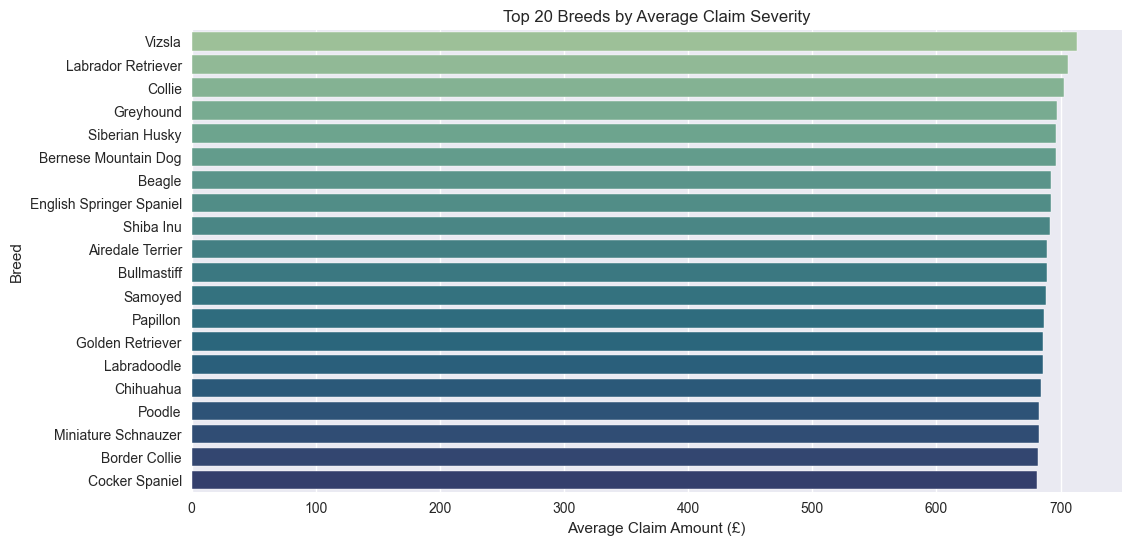

In [175]:
breed_severity = (
    model_df.groupby("breed")["severity"]
    .mean()
    .sort_values(ascending=False)
    .head(20)
)

breed_severity

plt.figure(figsize=(12,6))
sns.barplot(
    y=breed_severity.index,
    x=breed_severity.values,
    palette=sns.color_palette('crest', n_colors=20)
)
plt.title("Top 20 Breeds by Average Claim Severity")
plt.xlabel("Average Claim Amount (£)")
plt.ylabel("Breed")
save_fig("insight_breeds_severity_top20")
plt.show()

### How does pet age affect policy risk and claim frequency?

In [176]:
age_freq = (
    model_df.groupby("age_bucket")["claim_id"]
    .count()
    .rename("claim_count")
)

age_freq

age_bucket
0-1     26274
1-3     22617
3-7     44070
7-12    55040
12+     46283
Name: claim_count, dtype: int64

C:\Users\leebe\AppData\Local\Temp\ipykernel_25176\2821153477.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_freq.index, y=age_freq.values, ax=ax[0], palette=sns.color_palette('crest', n_colors=5))
C:\Users\leebe\AppData\Local\Temp\ipykernel_25176\2821153477.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_sev.index, y=age_sev.values, ax=ax[1], palette=sns.color_palette('crest', n_colors=5))


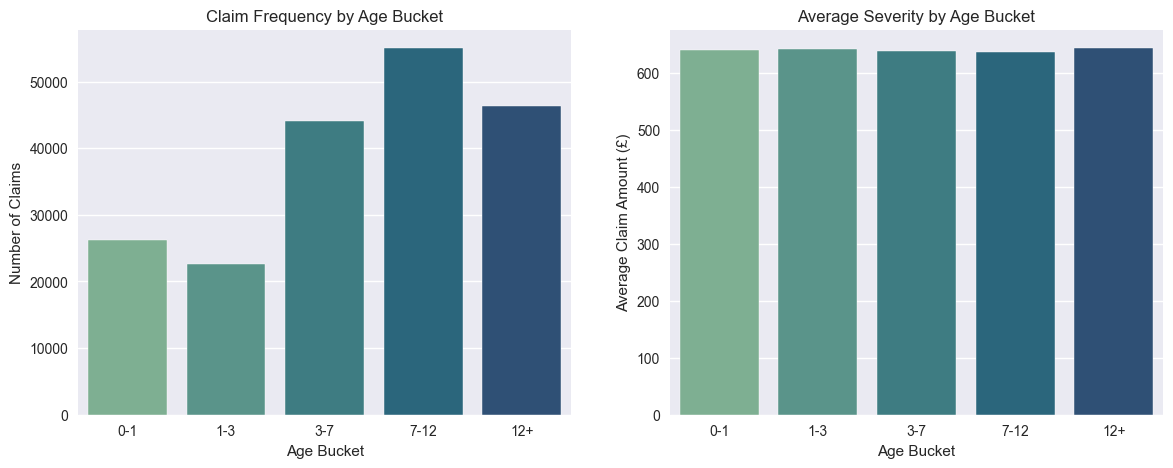

In [177]:
age_sev = (
    model_df.groupby("age_bucket")["severity"]
    .mean()
    .rename("avg_severity")
)

age_sev

fig, ax = plt.subplots(1, 2, figsize=(14,5))

sns.barplot(x=age_freq.index, y=age_freq.values, ax=ax[0], palette=sns.color_palette('crest', n_colors=5))
ax[0].set_title("Claim Frequency by Age Bucket")
ax[0].set_xlabel("Age Bucket")
ax[0].set_ylabel("Number of Claims")

sns.barplot(x=age_sev.index, y=age_sev.values, ax=ax[1], palette=sns.color_palette('crest', n_colors=5))
ax[1].set_title("Average Severity by Age Bucket")
ax[1].set_xlabel("Age Bucket")
ax[1].set_ylabel("Average Claim Amount (£)")

save_fig("insight_age_claims_frequency_severity")
plt.show()

### What is the loss ratio by product and coverage type?

C:\Users\leebe\AppData\Local\Temp\ipykernel_25176\948286369.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


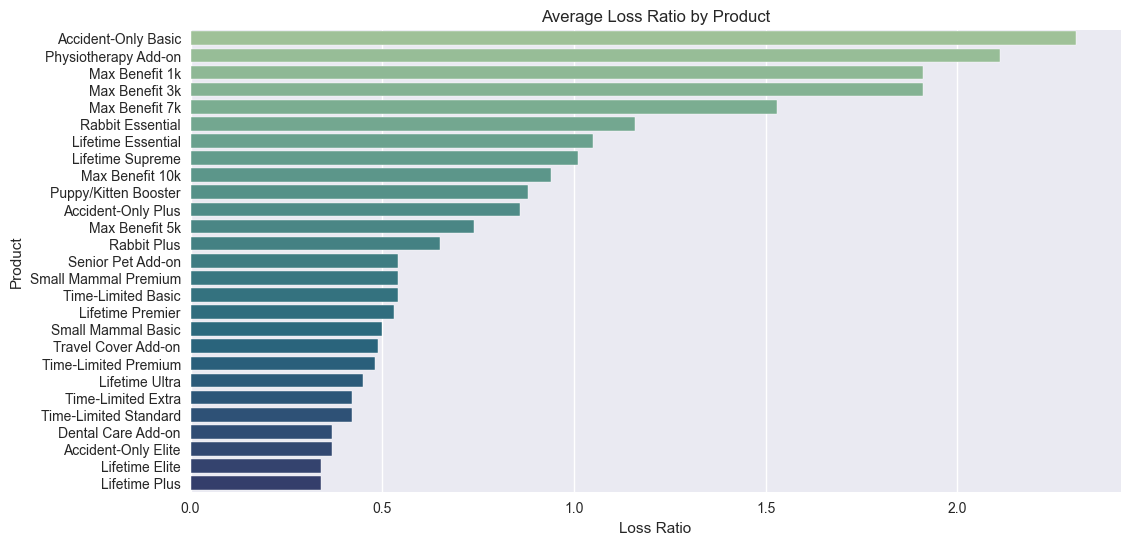

In [178]:
product_lr = (
    model_df.groupby("product_name")["loss_ratio"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12,6))
sns.barplot(
    y=product_lr.index,
    x=product_lr.values,
    palette="crest"
)
plt.title("Average Loss Ratio by Product")
plt.xlabel("Loss Ratio")
plt.ylabel("Product")
save_fig("insights_loss_ratio_by_product")
plt.show()

###  Loss ratio by coverage type

C:\Users\leebe\AppData\Local\Temp\ipykernel_25176\2545850783.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


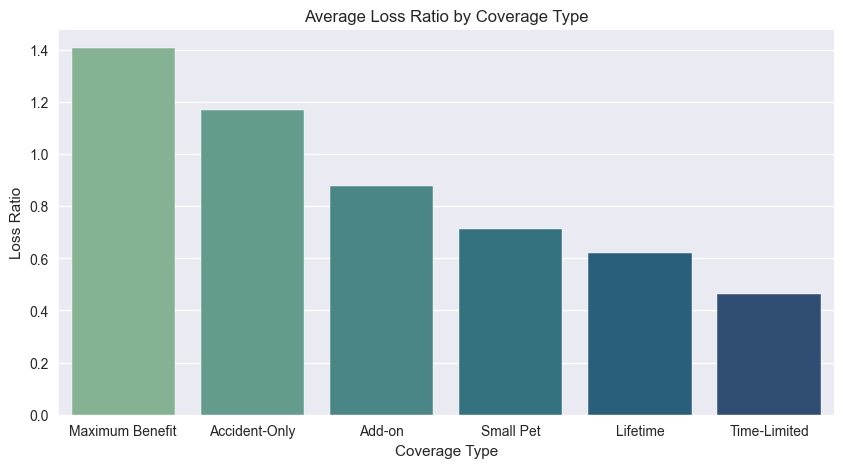

In [179]:
coverage_lr = (
    model_df.groupby("coverage_type")["loss_ratio"]
    .mean()
    .sort_values(ascending=False)
)

coverage_lr

plt.figure(figsize=(10,5))
sns.barplot(
    x=coverage_lr.index,
    y=coverage_lr.values,
    palette="crest"
)
plt.title("Average Loss Ratio by Coverage Type")
plt.xlabel("Coverage Type")
plt.ylabel("Loss Ratio")
save_fig("loss_ratio_by_coverage_type")
plt.show()


### Customer Lifetime Value (CLV) distribution

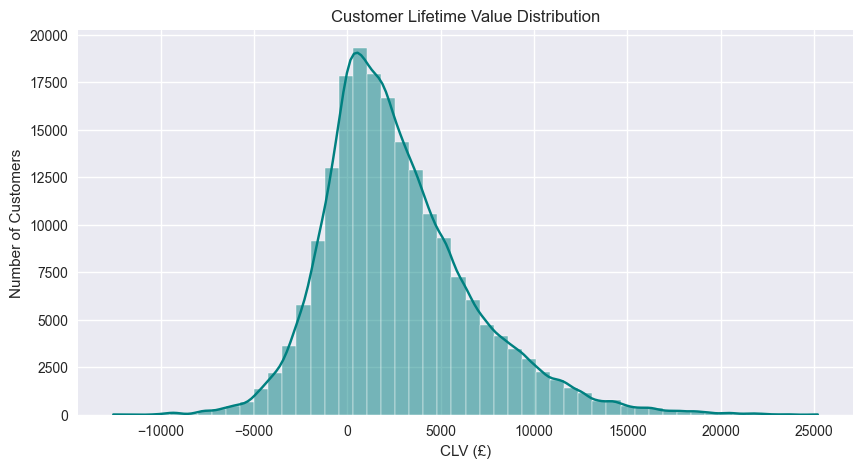

In [180]:
plt.figure(figsize=(10,5))
sns.histplot(model_df["CLV"], bins=50, kde=True, color="teal")
plt.title("Customer Lifetime Value Distribution")
plt.xlabel("CLV (£)")
plt.ylabel("Number of Customers")
save_fig("insights_clv_distribution")
plt.show()

### Customer Lifetime Value (CLV) by product

C:\Users\leebe\AppData\Local\Temp\ipykernel_25176\3603596676.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


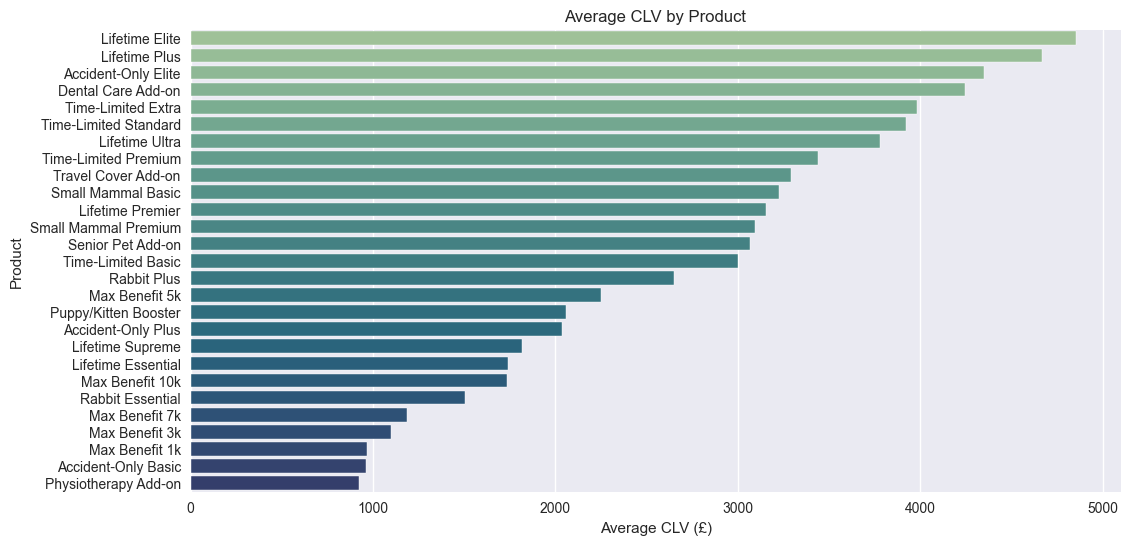

In [181]:
clv_by_product = (
    model_df.groupby("product_name")["CLV"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12,6))
sns.barplot(
    y=clv_by_product.index,
    x=clv_by_product.values,
    palette="crest"
)
plt.title("Average CLV by Product")
plt.xlabel("Average CLV (£)")
plt.ylabel("Product")
save_fig("insights_clv_by_product")
plt.show()

C:\Users\leebe\AppData\Local\Temp\ipykernel_25176\1978276870.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


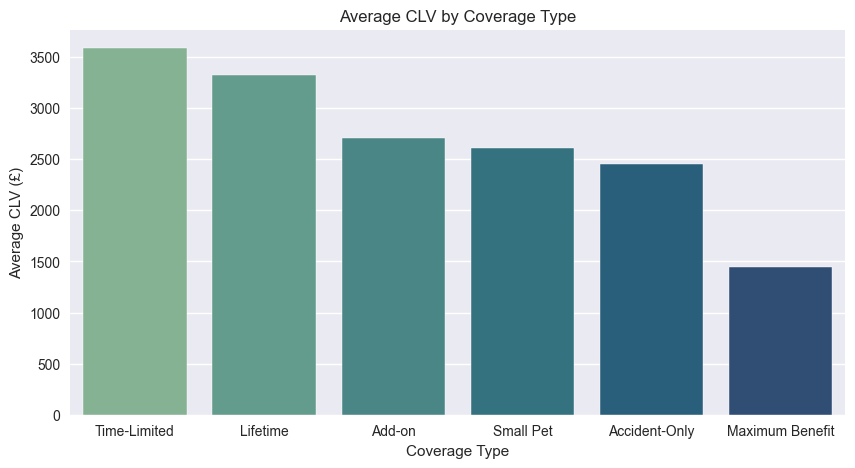

In [182]:
clv_by_coverage = (
    model_df.groupby("coverage_type")["CLV"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
sns.barplot(
    x=clv_by_coverage.index,
    y=clv_by_coverage.values,
    palette="crest"
)
plt.title("Average CLV by Coverage Type")
plt.xlabel("Coverage Type")
plt.ylabel("Average CLV (£)")
save_fig("insights_clv_by_coverage")
plt.show()

### Vet clinic cost analysis

C:\Users\leebe\AppData\Local\Temp\ipykernel_25176\2877343609.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


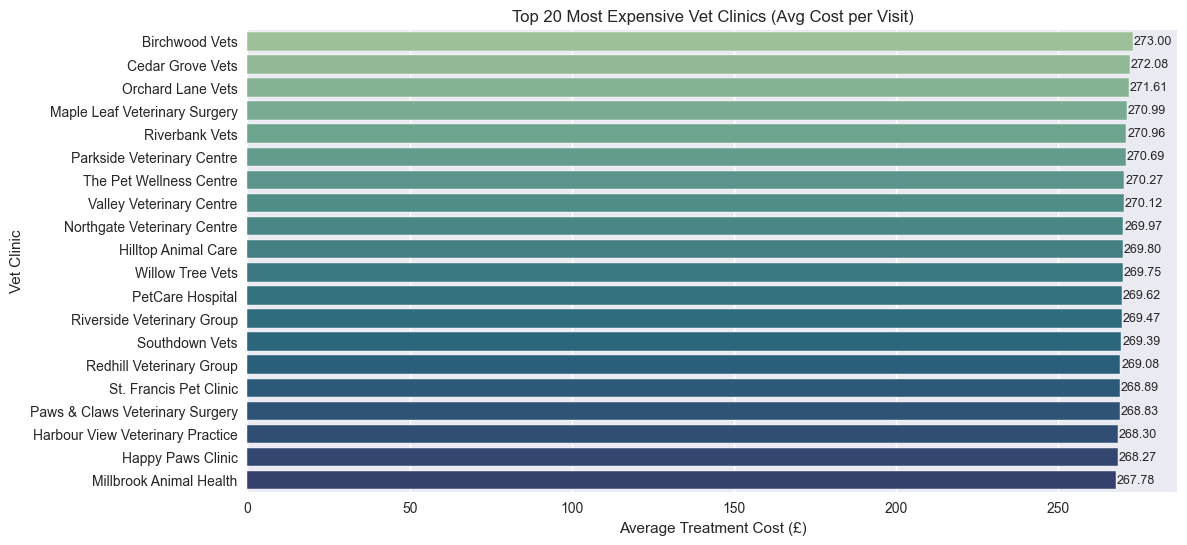

In [183]:
clinic_costs = (
    vet_costs.groupby("vet_clinic")["cost"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12,6))
sns.barplot(
    y=clinic_costs.head(20).index,
    x=clinic_costs.head(20).values,
    palette="crest"
)

for i, clinic in enumerate(clinic_costs.head(20).index):
    value = clinic_costs[clinic]
    plt.text(value + 0.3, i, f"{value:.2f}", va='center', fontsize=9)

plt.title("Top 20 Most Expensive Vet Clinics (Avg Cost per Visit)")
plt.xlabel("Average Treatment Cost (£)")
plt.ylabel("Vet Clinic")
save_fig("insights_clinic_costs_top20")
plt.show()

### Most visited vet clinics

C:\Users\leebe\AppData\Local\Temp\ipykernel_25176\2147119962.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


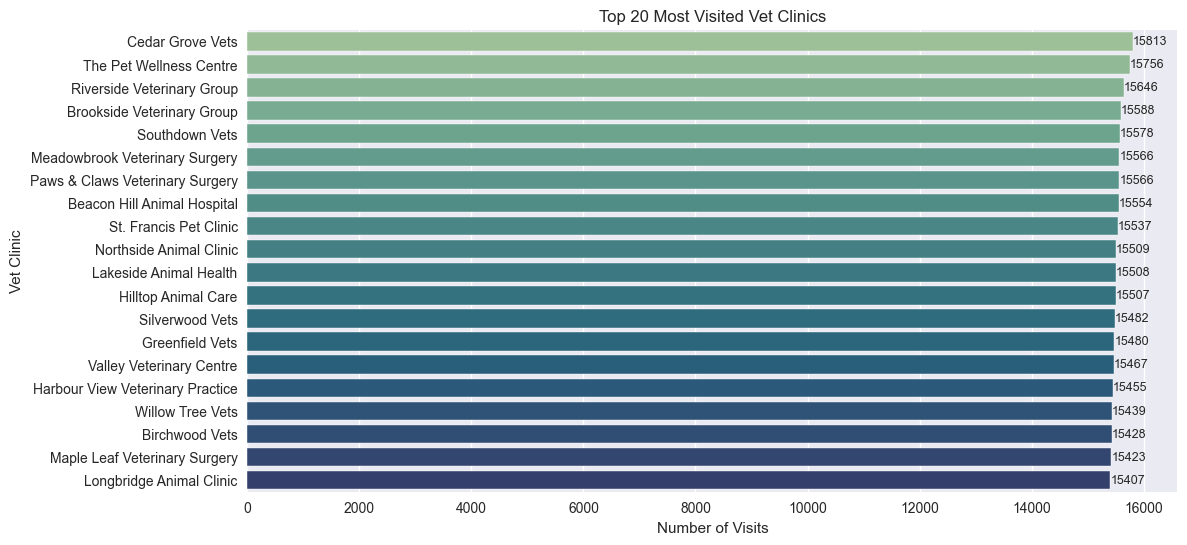

In [184]:
clinic_visits = (
    vet_costs.groupby("vet_clinic")["visit_id"]
    .count()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12,6))
sns.barplot(
    y=clinic_visits.head(20).index,
    x=clinic_visits.head(20).values,
    palette="crest"
)

for i, clinic in enumerate(clinic_visits.head(20).index):
    value = clinic_visits[clinic]
    plt.text(value + 0.3, i, f"{value:.0f}", va='center', fontsize=9)
    
plt.title("Top 20 Most Visited Vet Clinics")
plt.xlabel("Number of Visits")
plt.ylabel("Vet Clinic")
save_fig("insights_clinic_visits_top20")
plt.show()

### High vet clinic cost outliers

In [185]:
q3 = clinic_costs.quantile(0.75)
iqr = clinic_costs.quantile(0.75) - clinic_costs.quantile(0.25)
threshold = q3 + 1.5 * iqr

high_cost_outliers = clinic_costs[clinic_costs > threshold]
print(high_cost_outliers)

Series([], Name: cost, dtype: float64)


### 

In [186]:
model_df["multi_pet"] = (model_df["pets_owned"] > 1).astype(int)

C:\Users\leebe\AppData\Local\Temp\ipykernel_25176\685432145.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


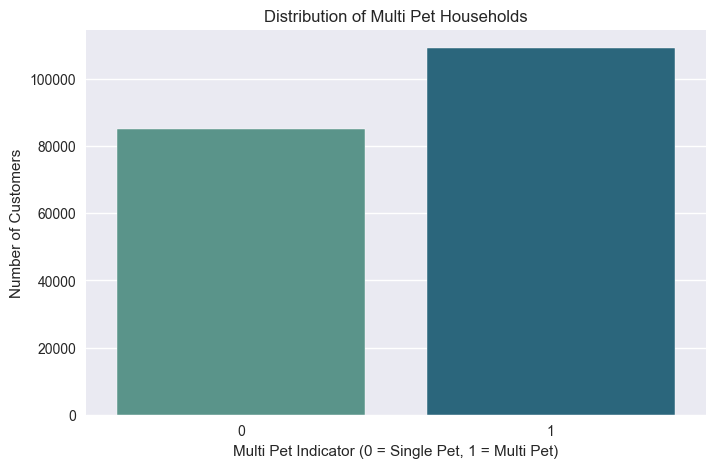

In [187]:
multi_pet_counts = model_df["multi_pet"].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(
    x=multi_pet_counts.index,
    y=multi_pet_counts.values,
    palette="crest"
)
plt.title("Distribution of Multi Pet Households")
plt.xlabel("Multi Pet Indicator (0 = Single Pet, 1 = Multi Pet)")
plt.ylabel("Number of Customers")
save_fig("insights_multi_pet_distribution")
plt.show()


###  Multi‑Pet vs CLV

C:\Users\leebe\AppData\Local\Temp\ipykernel_25176\439004000.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


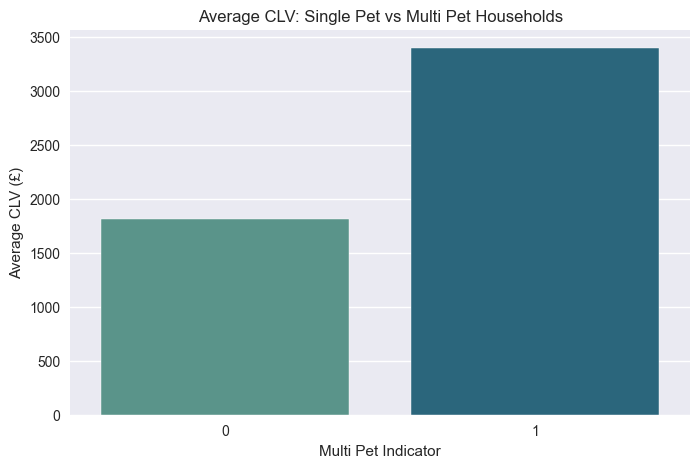

In [188]:
clv_by_multi = model_df.groupby("multi_pet")["CLV"].mean()

plt.figure(figsize=(8,5))
sns.barplot(
    x=clv_by_multi.index,
    y=clv_by_multi.values,
    palette="crest"
)
plt.title("Average CLV: Single Pet vs Multi Pet Households")
plt.xlabel("Multi Pet Indicator")
plt.ylabel("Average CLV (£)")
save_fig("insights_clv_by_multi_pet")
plt.show()

In [189]:
model_df.to_csv("C:\\Users\\leebe\\Documents\\GitHub\\Professional-Portfolio\\Pet Insurance Analytics Project\\data\\processed\\model_dataset.csv", index=False)
model_df.to_csv("C:\\Users\\leebe\\Documents\\GitHub\\Professional-Portfolio\\Pet Insurance Analytics Project\\tableau\\model_dataset.csv", index=False)

# Insights and Summary

### Breed Risk Insights
- Average claim severity varies meaningfully across breeds, with a clear spread from the highest‑cost breeds (e.g., Vizsla, Labrador Retriever, Collie) down to lower‑severity breeds such as Cocker Spaniels and Miniature Schnauzers.
- Higher‑severity breeds tend to include larger or more active dogs, which are often predisposed to musculoskeletal issues or injuries that drive up treatment costs.
- A small cluster of breeds sits noticeably above the rest, forming a distinct high‑severity tier. These outliers may warrant closer underwriting attention or more refined pricing to reflect their elevated cost profile

### Age‑Based Risk
- Claim frequency increases steadily as pets age, peaking in the 7–12 age bucket, before showing a slight drop in the 12+ group. 
- Mid‑to‑older pets generate the highest volume of claims, likely due to age‑related conditions becoming more common.
- Average claim severity, however, remains broadly consistent across all age buckets, with only a modest uplift in the 12+ category. 
- This indicates that while older pets claim more often, the cost per claim does not rise sharply with age — meaning frequency, not severity, is the primary driver of total cost in older cohorts.

### Product & Coverage Profitability
- Several products show loss ratios above 1.0, indicating they are unprofitable under current pricing.
- Lifetime products tend to have higher loss ratios, reflecting long‑term coverage of chronic conditions.
- Accident‑only and some Maximum Benefit products show stronger profitability, with loss ratios well below 1.0.
- These patterns highlight opportunities for pricing adjustments and product optimisation.

### Customer Lifetime Value (CLV)
- CLV displays a wide distribution, with clear separation between profitable and unprofitable customers.
- High‑value customers typically have lower claim severity, fewer chronic conditions, and longer tenure.
- Negative CLV is driven by high‑severity claims, frequent vet visits, or utilisation of high‑cost clinics.
- Product‑level CLV differences mirror loss ratio patterns, reinforcing the need for targeted pricing strategies.

### Vet Clinic Cost Analysis
- A small number of clinics show significantly higher average treatment costs, forming a distinct high‑cost tail.
- The most visited clinics are not always the most expensive, suggesting regional or behavioural utilisation patterns.
- Some clinics exhibit high average severity, indicating complex case mixes or potential over‑treatment.
- High‑cost, high‑severity clinics emerge as outliers that may warrant further investigation or negotiation.

### Multi‑Pet Households
- Multi‑pet households represent a meaningful share of the portfolio and show distinct behavioural patterns.
- These customers often contribute higher total premiums and may exhibit higher CLV.
- They may also show correlated risk, especially when multiple pets visit the same clinic or share environmental exposures.
- Multi‑pet customers are strong candidates for retention strategies, loyalty incentives, and cross‑sell opportunities.
